In [120]:
import pandas as pd
from scipy.stats import boxcox

import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
female_births = pd.read_csv(r"C:\Users\pc\PycharmProjects\Netology\Homework\timeseries\Series\daily-total-female-births-in-cal.csv")



In [122]:
all_series = {
    "Daily total female births in California": female_births["Count"]
}

In [123]:
daily_total_female_births_in_California = all_series['Daily total female births in California']

In [124]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


In [125]:
stat_daily_total_female_births_in_California = boxcox(all_series['Daily total female births in California'], 0)

In [126]:
day = 1

In [127]:
stat_daily_total_female_births_in_California = stat_daily_total_female_births_in_California[day:] - stat_daily_total_female_births_in_California[:-day]

In [170]:
series = daily_total_female_births_in_California


In [173]:
def initial_trend(series, season_len,i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [174]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [175]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen,i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [176]:
train, test, val = series[:60], series[60:70], series[70:]

In [177]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 1, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [178]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [179]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 89.7044203997711
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.98951965e-05, -1.62003744e-04, -0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([1.        , 0.05543299, 1.        ])


In [182]:
def plot_tema(alpha, beta, gamma, ser=daily_total_female_births_in_California, ser_to_plot=daily_total_female_births_in_California, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

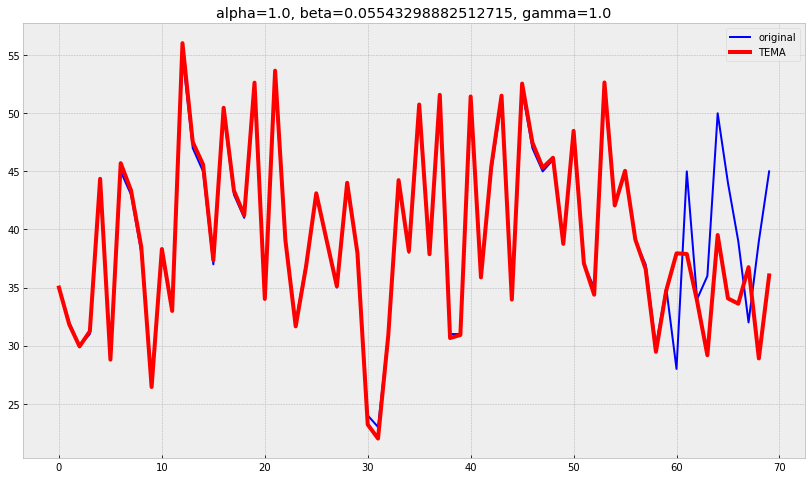

In [183]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

In [184]:
#Стационарный ряд

series = stat_daily_total_female_births_in_California

In [185]:
train, test, val = series[:60], series[60:70], series[70:]

In [201]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 1, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [202]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [203]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.08090135486076759
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.        ,  1.18935654, -0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1., 0., 1.])


In [204]:
def plot_tema(alpha, beta, gamma, ser=stat_daily_total_female_births_in_California, ser_to_plot=stat_daily_total_female_births_in_California, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

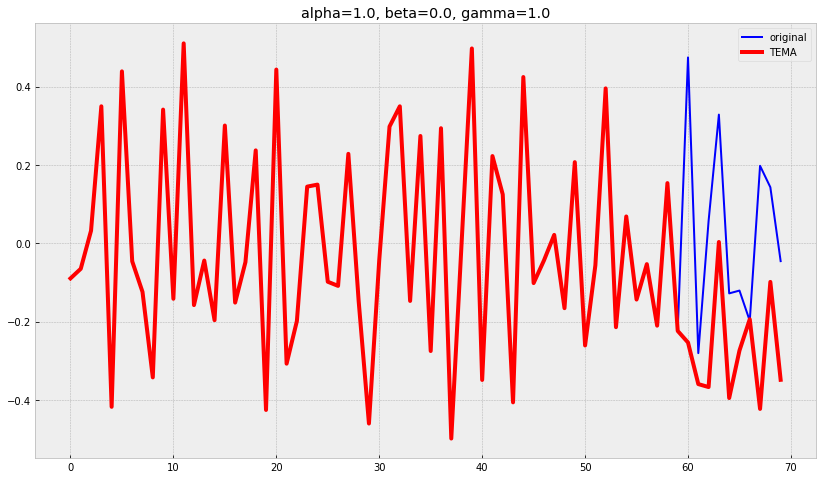

In [205]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))